In [53]:
import pandas as pd

# Load the dataset (adjust path as needed)
df = pd.read_csv("/Users/kendragugugu/Desktop/MGMT 59000/project/archive/flights.csv")

/var/folders/07/vjfc1td1021ds7khwx7c9c300000gn/T/ipykernel_26080/2208951400.py:4: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/kendragugugu/Desktop/MGMT 59000/project/archive/flights.csv")


# LP: Maximize total delay reduction

2.3 dynamic effort units

In [54]:
import pandas as pd
import numpy as np
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, LpStatus, value

# === Load and Clean Delay Weight Data ===
excel_path = "/Users/kendragugugu/Desktop/MGMT 59000/project/DelayCause_03_23.xlsx"
df_delay_raw = pd.read_excel(excel_path, sheet_name='Delay Cause by Year')

df_delay_raw.columns = ["Year", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "AIR_SYSTEM_DELAY", "SECURITY_DELAY", "WEATHER_DELAY"]
df_delay_clean = df_delay_raw[1:]  # Drop embedded header row

for col in df_delay_clean.columns[1:]:
    df_delay_clean[col] = pd.to_numeric(df_delay_clean[col], errors='coerce')

avg_percent = df_delay_clean.mean(numeric_only=True)
weights = (1 / avg_percent) * 100
weights = weights.round(2)

# === Filter main dataset in memory as `df` ===
filtered_df = df[~(
    df['AIR_SYSTEM_DELAY'].isna() &
    df['SECURITY_DELAY'].isna() &
    df['AIRLINE_DELAY'].isna() &
    df['LATE_AIRCRAFT_DELAY'].isna() &
    df['WEATHER_DELAY'].isna()
)]

# === Compute 60% caps for each delay type ===
avg_caps = {
    "AIRLINE_DELAY": filtered_df["AIRLINE_DELAY"].mean(skipna=True) * 0.6,
    "LATE_AIRCRAFT_DELAY": filtered_df["LATE_AIRCRAFT_DELAY"].mean(skipna=True) * 0.6,
    "AIR_SYSTEM_DELAY": filtered_df["AIR_SYSTEM_DELAY"].mean(skipna=True) * 0.6,
    "SECURITY_DELAY": filtered_df["SECURITY_DELAY"].mean(skipna=True) * 0.6,
    "WEATHER_DELAY": filtered_df["WEATHER_DELAY"].mean(skipna=True) * 0.6
}

# === Prepare to loop over budgets ===
results = []
min_weather_commit = 0.6
budget_range = range(1, 201)

for effort_budget in budget_range:
    model = LpProblem("Maximize_Total_Delay_Reduction", LpMaximize)

    x = {
        "AIRLINE_DELAY": LpVariable("x_airline", 0, avg_caps["AIRLINE_DELAY"]),
        "LATE_AIRCRAFT_DELAY": LpVariable("x_late", 0, avg_caps["LATE_AIRCRAFT_DELAY"]),
        "AIR_SYSTEM_DELAY": LpVariable("x_airsys", 0, avg_caps["AIR_SYSTEM_DELAY"]),
        "SECURITY_DELAY": LpVariable("x_sec", 0, avg_caps["SECURITY_DELAY"]),
        "WEATHER_DELAY": LpVariable("x_weather", 0, avg_caps["WEATHER_DELAY"])
    }

    y_weather = LpVariable("y_weather", cat="Binary")

    total_reduction = lpSum([x[d] for d in x])
    model += total_reduction

    # Constraint: effort budget
    model += lpSum([weights[d] * x[d] for d in x]) <= effort_budget

    # Weather logic
    model += x["WEATHER_DELAY"] >= y_weather * min_weather_commit
    model += x["WEATHER_DELAY"] <= y_weather * avg_caps["WEATHER_DELAY"]

    # 40% cap on any one source
    for d in x:
        model += x[d] <= 0.4 * total_reduction

    model.solve()

    result_row = {"EffortBudget": effort_budget}
    for d in x:
        result_row[d] = x[d].varValue if x[d].varValue else 0.0
    result_row["TotalDelayReduced"] = value(model.objective)
    result_row["Status"] = LpStatus[model.status]
    results.append(result_row)

# === Convert to DataFrame ===
df_results = pd.DataFrame(results)

# === Smoothing logic: classify regimes based on consistent delay type set ===
def active_types(row, threshold=0.01):
    return tuple(sorted([d for d in avg_caps if row[d] > threshold]))

df_results["ActiveTypes"] = df_results.apply(active_types, axis=1)

# Group effort budgets into regime blocks
df_results["RegimeID"] = (df_results["ActiveTypes"] != df_results["ActiveTypes"].shift()).cumsum()

# Preview output
print(df_results)

/var/folders/07/vjfc1td1021ds7khwx7c9c300000gn/T/ipykernel_26080/2126088121.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_delay_clean[col] = pd.to_numeric(df_delay_clean[col], errors='coerce')


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/07/vjfc1td1021ds7khwx7c9c300000gn/T/e6983043d87447edad97ece5ee273a92-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/07/vjfc1td1021ds7khwx7c9c300000gn/T/e6983043d87447edad97ece5ee273a92-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 13 COLUMNS
At line 55 RHS
At line 64 BOUNDS
At line 71 ENDATA
Problem MODEL has 8 rows, 6 columns and 34 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.320718 - 0.00 seconds
Cgl0004I processed model has 5 rows, 4 columns (0 integer (0 of which binary)) and 20 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -0.320718 to -1.79769e+308
Probing was t

# ✅ Insight: Find the threshold where additional effort stops increasing total delay reduction


In [58]:
# === Find plateau point: first effort budget where TotalDelayReduced stops increasing ===
df_results["DeltaDelay"] = df_results["TotalDelayReduced"].diff().fillna(df_results["TotalDelayReduced"].iloc[0])

# Threshold: treat < epsilon as "no change"
epsilon = 0.001
plateau_start = df_results[df_results["DeltaDelay"] < epsilon].EffortBudget.min()

if pd.isna(plateau_start):
    print("No plateau found — delay reduction keeps increasing through entire budget range.")
else:
    print(f"\n🚨 Plateau begins at effort budget: {plateau_start}")

    # Extract the first row at the plateau
    plateau_row = df_results[df_results["EffortBudget"] == plateau_start].iloc[0]

    print("\n✔️ Total minutes of delay reduced at plateau:", round(plateau_row["TotalDelayReduced"], 2))
    print("\n📊 Distribution across delay types at plateau:")

    for delay_type in delay_types:
        print(f"  {delay_type}: {round(plateau_row[delay_type], 2)} min")

    # Optional: check if allocations remain constant afterward
    plateau_df = df_results[df_results["EffortBudget"] >= plateau_start]
    all_same_alloc = plateau_df[delay_types].nunique() == 1

    if all_same_alloc.all():
        print("\n✔️ Delay allocations also remain constant after this point.")
    else:
        print("\n⚠️ Delay allocations still vary slightly even though total delay is constant.")


🚨 Plateau begins at effort budget: 166

✔️ Total minutes of delay reduced at plateau: 35.35

📊 Distribution across delay types at plateau:
  AIRLINE_DELAY: 11.38 min
  LATE_AIRCRAFT_DELAY: 14.08 min
  AIR_SYSTEM_DELAY: 8.09 min
  SECURITY_DELAY: 0.05 min
  WEATHER_DELAY: 1.75 min

✔️ Delay allocations also remain constant after this point.


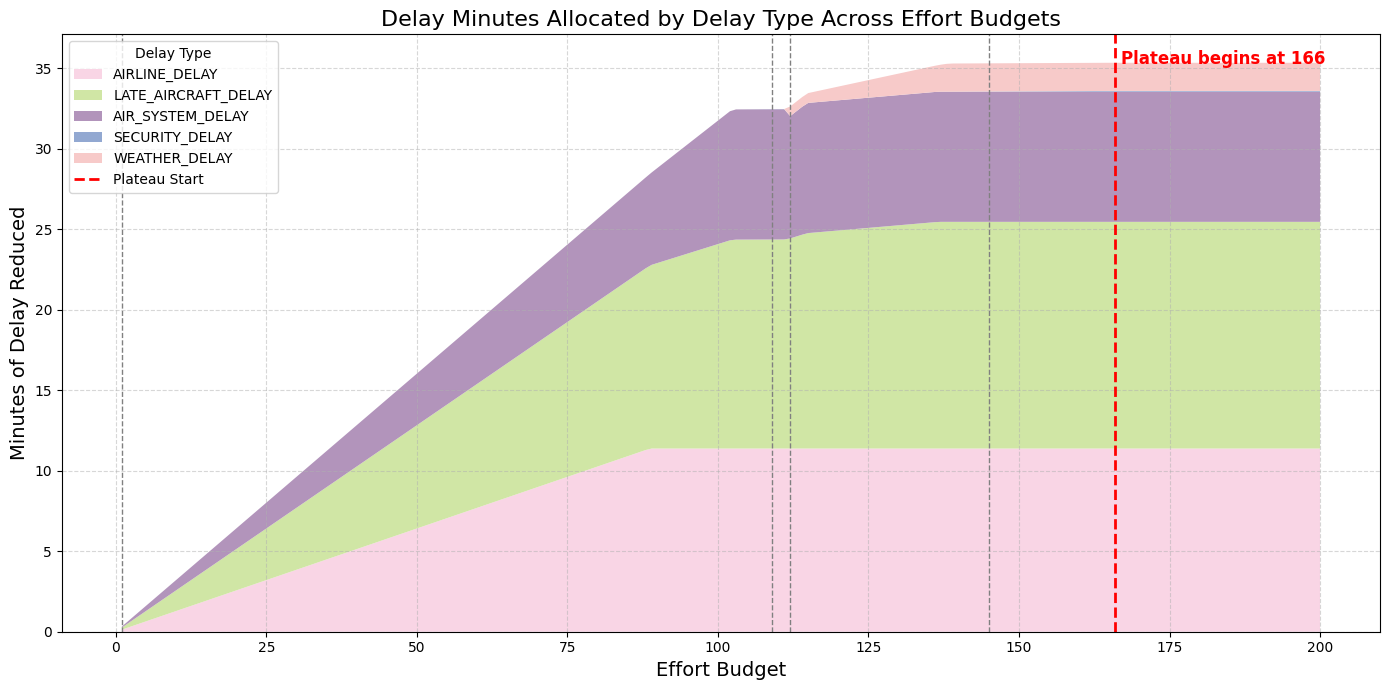

In [79]:
import matplotlib.pyplot as plt

# === Set up colors and delay types ===
delay_types = ["AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "AIR_SYSTEM_DELAY", "SECURITY_DELAY", "WEATHER_DELAY"]
colors = [
    '#f9d5e5',  # light pink (light)
    '#d0e6a5',  # mint green (light)
    '#b294bb',  # muted purple (dark)
    '#92a8d1',  # desaturated blue (dark)
    '#f7cac9'   # rose quartz (mid-tone anchor)
]

# === Plot stacked area chart ===
plt.figure(figsize=(14, 7))

plt.stackplot(
    df_results["EffortBudget"],
    [df_results[d] for d in delay_types],
    labels=delay_types,
    colors=colors
)

# Add vertical lines at regime breakpoints
regime_change_points = df_results[df_results["RegimeID"] != df_results["RegimeID"].shift()]["EffortBudget"]
for x in regime_change_points:
    plt.axvline(x=x, color="gray", linestyle="--", linewidth=1)

# Add plateau vertical line
if not pd.isna(plateau_start):
    plt.axvline(x=plateau_start, color="red", linestyle="--", linewidth=2, label="Plateau Start")
    plt.text(
        x=plateau_start + 1,  # slightly offset so text doesn't sit directly on the line
        y=plt.ylim()[1] * 0.95,
        s=f"Plateau begins at {int(plateau_start)}",
        color="red",
        fontsize=12,
        fontweight="bold"
    )

# Labels and legend
plt.title("Delay Minutes Allocated by Delay Type Across Effort Budgets", fontsize=16)
plt.xlabel("Effort Budget", fontsize=14)
plt.ylabel("Minutes of Delay Reduced", fontsize=14)
plt.legend(title="Delay Type", loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Table 1: Average % Contribution per Delay Type for Each Regime

In [80]:
# === Step 1: Calculate percentage contribution per delay type for each row ===
for delay in delay_types:
    df_results[f"{delay}_PCT"] = df_results[delay] / df_results["TotalDelayReduced"]

# === Step 2: Group by regime and compute average percentage contribution ===
avg_pct_per_regime = (
    df_results.groupby("RegimeID")[[f"{d}_PCT" for d in delay_types]]
    .mean()
    .multiply(100)  # convert to %
    .round(2)
    .reset_index()
)

# === Step 3: Add regime budget range and active types info ===
regime_ranges = (
    df_results.groupby("RegimeID")
    .agg(EffortBudget_Min=("EffortBudget", "min"),
         EffortBudget_Max=("EffortBudget", "max"),
         ActiveTypes=("ActiveTypes", lambda x: ", ".join(sorted(set(x.iloc[0])))))
    .reset_index()
)

avg_pct_per_regime = avg_pct_per_regime.merge(regime_ranges, on="RegimeID")

# === Step 4: Reorder columns for clarity ===
ordered_cols = ["RegimeID", "EffortBudget_Min", "EffortBudget_Max", "ActiveTypes"] + [f"{d}_PCT" for d in delay_types]
avg_pct_per_regime = avg_pct_per_regime[ordered_cols]

# === Step 5: Rename columns nicely for presentation ===
col_rename = {
    f"{d}_PCT": d.replace("_", " ").title() + " %"
    for d in delay_types
}
avg_pct_per_regime.rename(columns=col_rename, inplace=True)

# === Step 6: Display output table ===
print("\n=== Average % Contribution of Each Delay Type by Regime ===")
print(avg_pct_per_regime.to_string(index=False))

# Optional: save to Excel
avg_pct_per_regime.to_excel("avg_delay_pct_by_regime.xlsx", index=False)


=== Average % Contribution of Each Delay Type by Regime ===
 RegimeID  EffortBudget_Min  EffortBudget_Max                                                                         ActiveTypes  Airline Delay %  Late Aircraft Delay %  Air System Delay %  Security Delay %  Weather Delay %
        1                 1               108                                AIRLINE_DELAY, AIR_SYSTEM_DELAY, LATE_AIRCRAFT_DELAY            39.40                  40.00               20.60              0.00             0.00
        2               109               111                AIRLINE_DELAY, AIR_SYSTEM_DELAY, LATE_AIRCRAFT_DELAY, SECURITY_DELAY            35.05                  40.00               24.91              0.04             0.00
        3               112               144                 AIRLINE_DELAY, AIR_SYSTEM_DELAY, LATE_AIRCRAFT_DELAY, WEATHER_DELAY            33.08                  39.98               23.42              0.00             3.52
        4               145            

# Visualization of the Table

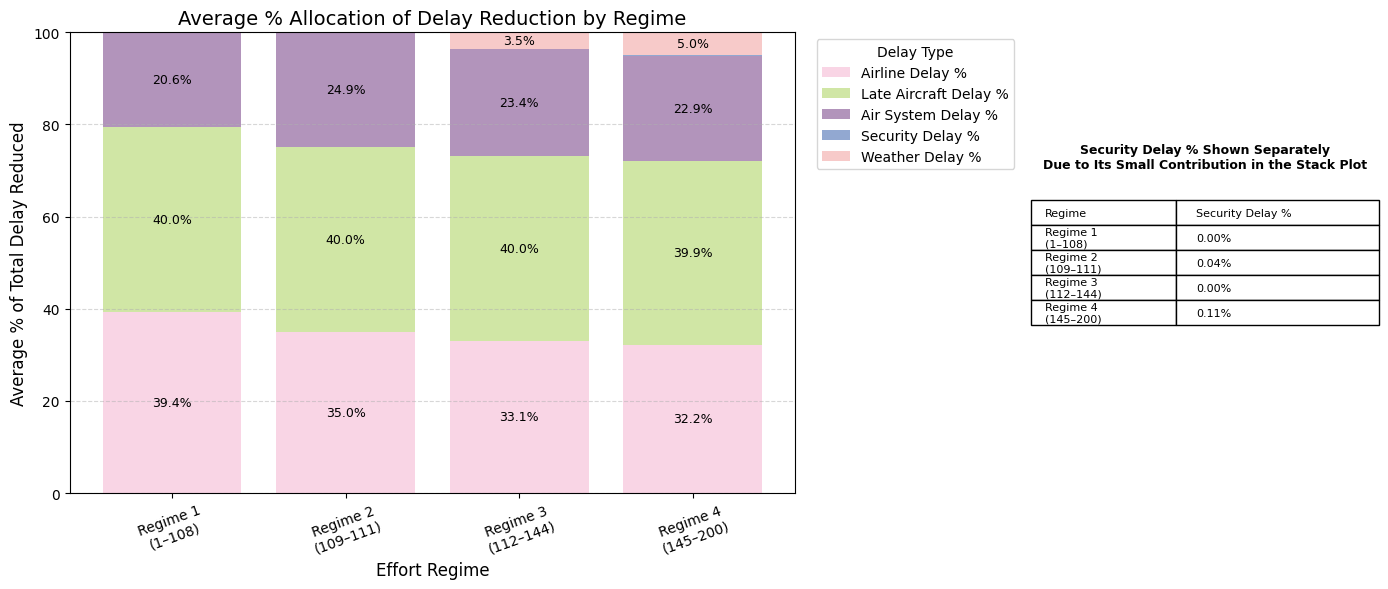

In [84]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

# === Setup figure with 2-column layout: chart (left) + table (right) ===
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])  # 3:1 ratio for main chart and table

# === LEFT: Stacked bar chart ===
ax0 = plt.subplot(gs[0])
bottoms = np.zeros(len(plot_df))

for i, delay in enumerate(bar_components):
    values = plot_df[delay].values
    bars = ax0.bar(plot_df["RegimeLabel"], values, bottom=bottoms, label=delay, color=colors[i])
    
    for j, (bar, val) in enumerate(zip(bars, values)):
        if val > 1:
            ax0.text(
                bar.get_x() + bar.get_width() / 2,
                bottoms[j] + val / 2,
                f"{val:.1f}%",
                ha="center", va="center", fontsize=9, color="black"
            )
    bottoms += values

ax0.set_title("Average % Allocation of Delay Reduction by Regime", fontsize=14)
ax0.set_ylabel("Average % of Total Delay Reduced", fontsize=12)
ax0.set_xlabel("Effort Regime", fontsize=12)
ax0.set_ylim(0, 100)
ax0.set_xticks(range(len(plot_df)))
ax0.set_xticklabels(plot_df["RegimeLabel"], rotation=20)
ax0.grid(axis="y", linestyle="--", alpha=0.5)
ax0.legend(title="Delay Type", bbox_to_anchor=(1.02, 1), loc="upper left")

# === RIGHT: Security Delay % Table ===
ax1 = plt.subplot(gs[1])
ax1.axis("off")  # Hide axes

# Add a header above the table
ax1.text(0.5, 0.7, 
         "Security Delay % Shown Separately\nDue to Its Small Contribution in the Stack Plot",
         ha="center", va="bottom", fontsize=9, weight='bold', wrap=True, transform=ax1.transAxes)

# Create table content
security_rows = list(zip(plot_df["RegimeLabel"], plot_df["Security Delay %"].round(2)))
table_data = [["Regime", "Security Delay %"]] + [[label, f"{val:.2f}%"] for label, val in security_rows]

# Draw table
table = ax1.table(cellText=table_data, loc="center", cellLoc="left", colWidths=[0.5, 0.7])
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.5)

# === Final formatting ===
plt.tight_layout()
plt.show()

In [63]:
# === Compute average delay minutes per delay type within each regime ===
avg_alloc_per_regime = (
    df_results.groupby("RegimeID")[delay_types]
    .mean()
    .reset_index()
    .round(2)
)

# Add regime effort ranges for context
avg_alloc_per_regime = avg_alloc_per_regime.merge(
    regime_summary[["RegimeID", "EffortBudget_Min", "EffortBudget_Max", "ActiveTypes"]],
    on="RegimeID",
    how="left"
)

# Reorder columns for clarity
cols = ["RegimeID", "EffortBudget_Min", "EffortBudget_Max", "ActiveTypes"] + delay_types
avg_alloc_per_regime = avg_alloc_per_regime[cols]

# Print table
print("\n=== Average Delay Minutes Per Type Within Each Regime ===")
print(avg_alloc_per_regime)

# Optional: save to Excel
avg_alloc_per_regime.to_excel("avg_delay_per_regime.xlsx", index=False)


=== Average Delay Minutes Per Type Within Each Regime ===
   RegimeID  EffortBudget_Min  EffortBudget_Max  \
0         1                 1               108   
1         2               109               111   
2         3               112               144   
3         4               145               200   

                                         ActiveTypes  AIRLINE_DELAY  \
0  AIRLINE_DELAY, AIR_SYSTEM_DELAY, LATE_AIRCRAFT...           6.76   
1  AIRLINE_DELAY, AIR_SYSTEM_DELAY, LATE_AIRCRAFT...          11.38   
2  AIRLINE_DELAY, AIR_SYSTEM_DELAY, LATE_AIRCRAFT...          11.38   
3  AIRLINE_DELAY, AIR_SYSTEM_DELAY, LATE_AIRCRAFT...          11.38   

   LATE_AIRCRAFT_DELAY  AIR_SYSTEM_DELAY  SECURITY_DELAY  WEATHER_DELAY  
0                 6.95              3.67            0.00           0.00  
1                12.99              8.09            0.01           0.00  
2                13.76              8.06            0.00           1.22  
3                14.08           

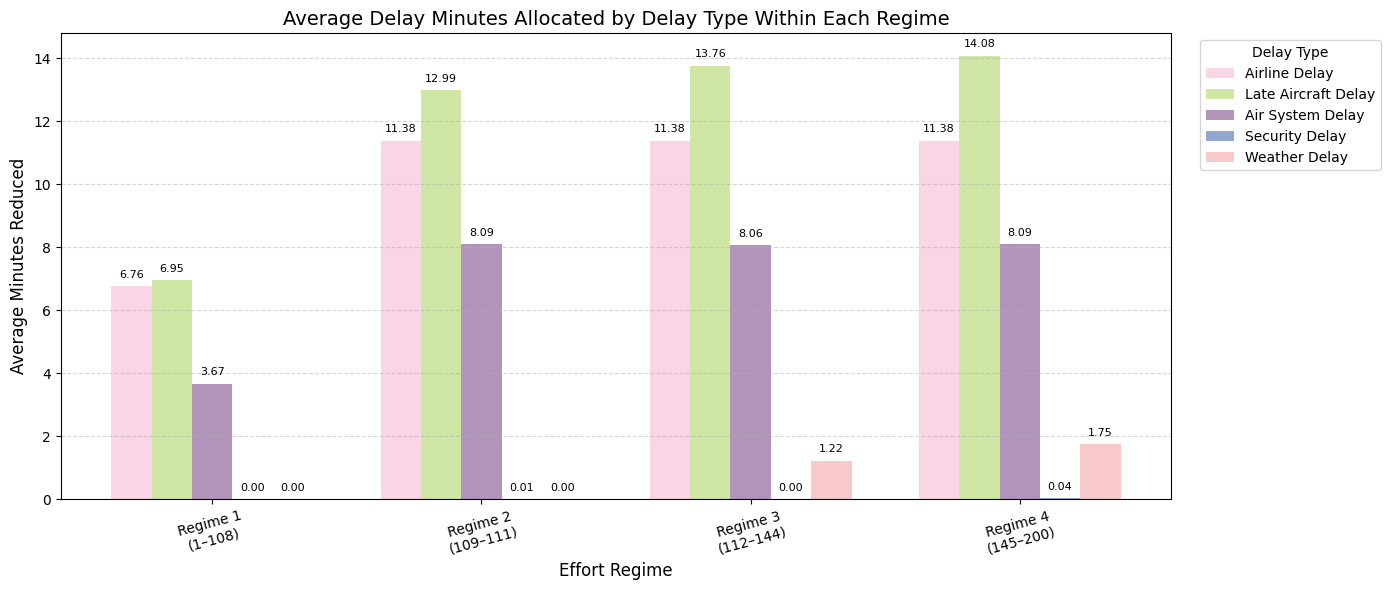

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# === Bar chart parameters ===
delay_labels = [d.replace("_", " ").title() for d in delay_types]
regime_labels = [f"Regime {int(row['RegimeID'])}\n({int(row['EffortBudget_Min'])}–{int(row['EffortBudget_Max'])})"
                 for _, row in avg_alloc_per_regime.iterrows()]

x = np.arange(len(regime_labels))  # X locations for each regime group
width = 0.15  # Width of each bar
n_delays = len(delay_types)

plt.figure(figsize=(14, 6))

# Plot each delay type as a group of bars
for i, delay in enumerate(delay_types):
    values = avg_alloc_per_regime[delay].values
    plt.bar(x + i * width, values, width, label=delay_labels[i], color=colors[i])
    
    # Annotate values
    for j, val in enumerate(values):
        plt.text(
            x[j] + i * width,
            val + 0.2,
            f"{val:.2f}",
            ha='center',
            va='bottom',
            fontsize=8
        )

# Formatting
plt.title("Average Delay Minutes Allocated by Delay Type Within Each Regime", fontsize=14)
plt.xlabel("Effort Regime", fontsize=12)
plt.ylabel("Average Minutes Reduced", fontsize=12)
plt.xticks(x + width * (n_delays - 1) / 2, regime_labels, rotation=15)
plt.legend(title="Delay Type", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [16]:
# === Generate regime summary table ===
regime_summary = (
    df_results.groupby("RegimeID")
    .agg(
        EffortBudget_Min=("EffortBudget", "min"),
        EffortBudget_Max=("EffortBudget", "max"),
        ActiveTypes=("ActiveTypes", lambda x: x.iloc[0])
    )
    .reset_index()
)

# Convert tuple of delay types into a comma-separated string
regime_summary["ActiveTypes"] = regime_summary["ActiveTypes"].apply(lambda x: ", ".join(x))

# Print the summary table
print("\n=== Regime Summary ===")
print(regime_summary)

# Optional: save to Excel
regime_summary.to_excel("effort_regime_summary.xlsx", index=False)


=== Regime Summary ===
   RegimeID  EffortBudget_Min  EffortBudget_Max  \
0         1                 1               108   
1         2               109               111   
2         3               112               144   
3         4               145               200   

                                         ActiveTypes  
0  AIRLINE_DELAY, AIR_SYSTEM_DELAY, LATE_AIRCRAFT...  
1  AIRLINE_DELAY, AIR_SYSTEM_DELAY, LATE_AIRCRAFT...  
2  AIRLINE_DELAY, AIR_SYSTEM_DELAY, LATE_AIRCRAFT...  
3  AIRLINE_DELAY, AIR_SYSTEM_DELAY, LATE_AIRCRAFT...  


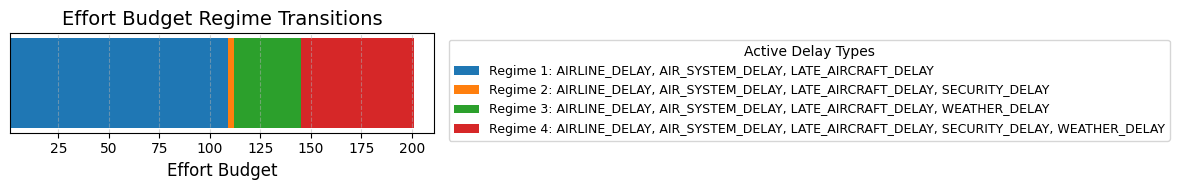

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 2))
for idx, row in regime_summary.iterrows():
    plt.barh(
        y=0,
        width=row["EffortBudget_Max"] - row["EffortBudget_Min"] + 1,
        left=row["EffortBudget_Min"],
        height=0.4,
        label=f"Regime {row['RegimeID']}: {row['ActiveTypes']}"
    )

plt.title("Effort Budget Regime Transitions", fontsize=14)
plt.xlabel("Effort Budget", fontsize=12)
plt.yticks([])  # Hide Y axis ticks
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="Active Delay Types", fontsize=9)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()